In [1]:
# 必要なライブラリのインストール
!pip install folium ipywidgets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 自然災害の世界的傾向と影響（1900年〜現在）- インタラクティブ分析

## 1. はじめに
このノートブックでは、EM-DAT（国際災害データベース）のデータセットを使用して、過去1世紀以上にわたる自然災害の傾向と、その人間社会への影響を分析します。

**インタラクティブ機能:**
以下のメニューから分析内容を切り替えて表示できます。
*   **Trend**: 災害発生頻度の経年変化
*   **Impact**: 災害の種類による人的被害（死者数）
*   **Region**: 地域ごとの災害発生傾向
*   **Map**: 災害発生地点の地図表示（HTMLファイルとしても保存されます）


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import ipywidgets as widgets
from IPython.display import display, clear_output

# グラフのスタイル設定
plt.style.use('ggplot') 

# データの読み込み
try:
    emdat = pd.read_csv('emdat.csv')
    print("データの読み込みに成功しました。")
except FileNotFoundError:
    print("エラー: 'emdat.csv' が見つかりません。このノートブックと同じフォルダに配置してください。")

# データの前処理
# 'Total Deaths' の欠損値を0で埋める
emdat['Total Deaths'] = emdat['Total Deaths'].fillna(0)
# 'Start Year' が欠損しているデータは削除
emdat = emdat.dropna(subset=['Start Year'])
# 'Start Year' を整数型に変換
emdat['Start Year'] = emdat['Start Year'].astype(int)

データの読み込みに成功しました。


In [3]:
from folium.plugins import MarkerCluster, HeatMap, MiniMap, Fullscreen, MousePosition, Geocoder, MeasureControl, Terminator, TimestampedGeoJson

def plot_map():
    # 緯度経度情報があるデータのみ抽出
    map_data = emdat.dropna(subset=['Latitude', 'Longitude'])
    
    # データが多すぎると重くなるため、直近のデータや件数を絞る
    # 例: 最新2000件に絞る
    map_data = map_data.sort_values('Start Year', ascending=False).head(2000)

    # 地図の初期化（中心を世界地図の中心付近に）
    # CartoDB Positronはデータが見やすいシンプルなベースマップです
    m = folium.Map(location=[20, 0], zoom_start=2, tiles='CartoDB positron')
    
    # 追加のタイルレイヤー（背景地図の切り替え用）
    folium.TileLayer('CartoDB dark_matter', name='ダークモード').add_to(m)
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
    
    # ヒートマップレイヤー（災害の集中度を可視化）
    heat_data = [[row['Latitude'], row['Longitude']] for index, row in map_data.iterrows()]
    HeatMap(heat_data, name='ヒートマップ', radius=15, blur=10, show=False).add_to(m)
    
    # マーカークラスター（多数のマーカーをまとめて表示）
    marker_cluster = MarkerCluster(name='クラスター').add_to(m)
    
    # 災害タイプごとの色定義
    disaster_types = map_data['Disaster Type'].unique()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen', 'darkblue', 'black']
    color_map = {dtype: colors[i % len(colors)] for i, dtype in enumerate(disaster_types)}
    
    for idx, row in map_data.iterrows():
        # ポップアップの内容をHTMLでリッチにする（日本語化）
        popup_html = f"""
        <div style="width:200px; font-family: sans-serif;">
            <h4 style="margin-bottom:5px;">{row['Disaster Type']}</h4>
            <hr style="margin:5px 0;">
            <b>発生年:</b> {row['Start Year']}<br>
            <b>国・地域:</b> {row['Country']}<br>
            <b>死者数:</b> {int(row['Total Deaths']):,}<br>
            <b>場所:</b> {row['Location'] if pd.notna(row['Location']) else '不明'}
        </div>
        """
        popup = folium.Popup(popup_html, max_width=265)
        
        # 死者数に応じてマーカーのサイズを変える（対数的なスケーリングなど）
        # ここでは簡易的に、死者数が多いほど大きく、最小サイズを3とする
        radius = 5
        if row['Total Deaths'] > 1000:
            radius = 15
        elif row['Total Deaths'] > 100:
            radius = 10
        
        # CircleMarkerを使用
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=radius,
            popup=popup,
            color=color_map.get(row['Disaster Type'], 'gray'),
            fill=True,
            fill_color=color_map.get(row['Disaster Type'], 'gray'),
            fill_opacity=0.7,
            tooltip=f"{row['Disaster Type']} ({row['Start Year']})"
        ).add_to(marker_cluster)

    # --- 追加機能 ---
    
    # 1. マウス位置の座標表示
    MousePosition(
        position='topright',
        separator=' | ',
        empty_string='NaN',
        lng_first=False,
        num_digits=4,
        prefix='Coordinates:'
    ).add_to(m)
    
    # 2. 地名検索機能
    Geocoder(collapsed=True, position='topleft', add_marker=True).add_to(m)
    
    # 3. 距離・面積計測ツール
    MeasureControl(
        position='bottomleft',
        primary_length_unit='meters',
        secondary_length_unit='miles',
        primary_area_unit='sqmeters',
        secondary_area_unit='acres'
    ).add_to(m)
    
    # 4. 昼夜の境界線（ターミネーター）
    # Terminator().add_to(m) # 視認性を考慮してコメントアウト（必要に応じて有効化）

    # 5. タイムスライダー (TimestampedGeoJson)
    # データの準備: GeoJSON形式に変換
    features = []
    for _, row in map_data.iterrows():
        # 日付形式にする (YYYY-MM-DD)
        date_str = f"{row['Start Year']}-01-01"
        
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['Longitude'], row['Latitude']],
            },
            'properties': {
                'time': date_str,
                'style': {'color': color_map.get(row['Disaster Type'], 'gray')},
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': color_map.get(row['Disaster Type'], 'gray'),
                    'fillOpacity': 0.8,
                    'stroke': 'false',
                    'radius': 5
                },
                'popup': f"{row['Disaster Type']} ({row['Start Year']})"
            }
        }
        features.append(feature)

    timestamped_geojson = TimestampedGeoJson(
        {'type': 'FeatureCollection', 'features': features},
        period='P1Y', # 1年ごとに更新
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY',
        time_slider_drag_update=True,
        duration='P1Y'
    )
    timestamped_geojson.add_to(m)

    # コントロールの追加
    folium.LayerControl().add_to(m)
    Fullscreen().add_to(m)
    MiniMap(toggle_display=True).add_to(m)
    
    # HTMLファイルとして保存
    m.save('disaster_map.html')
    
    display(m)
    print("地図を更新しました。以下の機能が追加されています：")
    print("・クラスタリング: ズームアウト時にマーカーをまとめます")
    print("・ヒートマップ: レイヤーコントロールから 'ヒートマップ' をオンにすると表示されます")
    print("・リッチポップアップ: マーカークリックで詳細情報を表示（日本語）")
    print("・背景地図切り替え: 右上のレイヤーアイコンから ダークモード などに変更可能")
    print("・座標表示: 右上にマウスカーソルの緯度経度を表示")
    print("・検索機能: 左上の虫眼鏡アイコンで地名を検索")
    print("・計測ツール: 左下の定規アイコンで距離や面積を計測")
    print("・タイムスライダー: 下部のスライダーで年ごとの災害発生状況をアニメーション表示")


In [4]:
def plot_trend():
    # 年ごとの災害発生件数を集計
    trend_data = emdat['Start Year'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data.index, trend_data.values, marker='o', linestyle='-')
    plt.title('Global Natural Disaster Frequency (1900-Present)')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.grid(True)
    plt.show()
    print("洞察: 20世紀後半から災害報告数が急増していることがわかります。これは気候変動の影響や、報告システムの改善などが要因として考えられます。")

def plot_impact():
    # 災害タイプごとの総死者数を集計
    impact_data = emdat.groupby('Disaster Type')['Total Deaths'].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    impact_data.plot(kind='bar', color='salmon')
    plt.title('Total Deaths by Disaster Type (1900-Present)')
    plt.xlabel('Disaster Type')
    plt.ylabel('Total Deaths')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("洞察: 地震 (Earthquake) や干ばつ (Drought)、洪水 (Flood) による人的被害が歴史的に甚大であることがわかります。")

def plot_region():
    # 地域ごとの災害発生件数を集計
    if 'Region' in emdat.columns:
        region_col = 'Region'
    else:
        region_col = 'Country'
        
    region_data = emdat[region_col].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    region_data.plot(kind='barh', color='skyblue')
    plt.title(f'Top 10 {region_col}s by Number of Disasters')
    plt.xlabel('Number of Disasters')
    plt.ylabel(region_col)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(f"洞察: アジア地域など、特定の地域で災害が頻発している傾向が見られます。")


以下のドロップダウンメニューから分析を選択してください：


Dropdown(description='Analysis:', options=('Trend', 'Impact', 'Region', 'Map'), value='Trend')

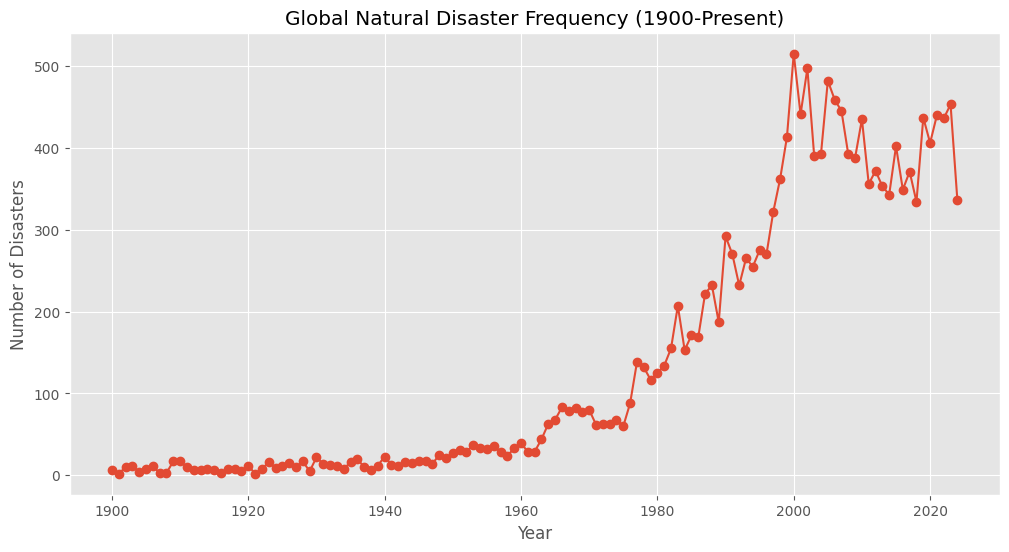

洞察: 20世紀後半から災害報告数が急増していることがわかります。これは気候変動の影響や、報告システムの改善などが要因として考えられます。


In [5]:
# インタラクティブな切り替え機能
def on_change(change):
    clear_output(wait=True)
    display(dropdown)
    if change['new'] == 'Trend':
        plot_trend()
    elif change['new'] == 'Impact':
        plot_impact()
    elif change['new'] == 'Region':
        plot_region()
    elif change['new'] == 'Map':
        plot_map()

dropdown = widgets.Dropdown(
    options=['Trend', 'Impact', 'Region', 'Map'],
    value='Trend',
    description='Analysis:',
    disabled=False,
)

dropdown.observe(on_change, names='value')

print("以下のドロップダウンメニューから分析を選択してください：")
display(dropdown)
plot_trend() # 初期表示